In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib.animation
import yaml
import cv2
from scipy.spatial.transform import Rotation
from matplotlib.patches import Rectangle
from tqdm import tqdm
import argparse

sys.path.append('/home/schiavazza/code/hpe/hpe-core/datasets/')
sys.path.append('/local_code/hpe-core/datasets/')

from vicon_processing.src.projection import ProjectionHelper
from vicon_processing.src.data_helpers import DvsLabeler, DvsHelper, C3dHelper
from vicon_processing.src import vis_utils, utils

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [11]:
def obj_delay(delay, label_start):
    r = 2
    # import the DVS data
    dvs_file_path = "/home/schiavazza/data/hpe/vicon_dataset/processed/simon/drum_s1/atis-d/"
    dvs_helper = DvsHelper(dvs_file_path)
    # read the labeled 2d points
    dvs_helper.read_points_labels("/home/schiavazza/data/hpe/vicon_dataset/processed/simon/drum_s1/atis_d_frames/labeled_points.yml");
    # extract the time of the labeled points
    print(len(dvs_helper.labeled_points['points']))
    s = max(0, label_start-r)
    e = min(len(dvs_helper.labeled_points['points']), label_start+r)

    labels_times = np.array(dvs_helper.labeled_points['times'][:])

    print(labels_times)
    # labels_times = [0.0]
    labels = list(dvs_helper.labeled_points['points'][0].keys())
    print(labels)


    # load c3d vicon data
    c3d_file_path = "/home/schiavazza/data/hpe/vicon_dataset/processed/simon/drum_s1.c3d"
    c3d_helper = C3dHelper(c3d_file_path, delay=delay, camera_markers=True)
    print(c3d_helper.reader.point_labels)
    c3d_helper.reader.frame_count

    vicon_labeled_frames = c3d_helper.get_frame_time(labels_times)
    print(c3d_helper.frame_times)
    vicon_points = c3d_helper.get_vicon_points_interpolated(vicon_labeled_frames, labels, labels_times)
    vicon_points_mark = c3d_helper.transform_points_to_marker_frame(vicon_points)
    # vicon_points_mark = vicon_points
    c3d_helper.markers_T
    print(f"times from dvs labels: {dvs_helper.labeled_points['times']}")
    print(f"times from vicon labels: {vicon_points_mark['times']}")
    dvs_helper.labeled_points['times']
    vicon_points_mark['times']
    proj_helper = ProjectionHelper(vicon_points_mark, dvs_helper.labeled_points)
    proj_helper.import_camera_calbration("/home/schiavazza/data/hpe/vicon_dataset/processed/simon/calib-d.txt");
    proj_helper.image_points

    # find transform
    T, result = proj_helper._find_R_t()
    print(result)

    return result.fun

In [12]:
def opt_delay(l_start):
    delays = np.linspace(0.21, 0.35, 100)
    res = []
    for d in delays:
        r = obj_delay(d, l_start)
        if r > 100: r = 100
        res.append(r)
    res = np.array(res)

    return res, delays

In [13]:
res, delays = opt_delay(5)

24
[2.27272727 2.55555556 2.83838384 2.97979798]
['P11:LFHD', 'P11:LFIN', 'P11:RFHD', 'P11:RFIN']
['camera:cam_right              ' 'camera:cam_back               '
 'camera:cam_left               ' 'P11:LFHD                      '
 'P11:RFHD                      ' 'P11:LBHD                      '
 'P11:RBHD                      ' 'P11:C7                        '
 'P11:T10                       ' 'P11:CLAV                      '
 'P11:STRN                      ' 'P11:RBAK                      '
 'P11:LSHO                      ' 'P11:LUPA                      '
 'P11:LELB                      ' 'P11:LFRM                      '
 'P11:LWRA                      ' 'P11:LWRB                      '
 'P11:LFIN                      ' 'P11:RSHO                      '
 'P11:RUPA                      ' 'P11:RELB                      '
 'P11:RFRM                      ' 'P11:RWRA                      '
 'P11:RWRB                      ' 'P11:RFIN                      '
 'P11:LASI                     

/home/schiavazza/.local/lib/python3.10/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')
/home/schiavazza/code/hpe/hpe-core/datasets/vicon_processing/src/projection.py:319: UserWarning: Desired error not necessarily achieved due to precision loss.
  warnings.warn(result.message)
/home/schiavazza/.local/lib/python3.10/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')


      fun: 16.505776139700025
 hess_inv: array([[ 5.86687229e-03,  5.44395141e-03, -3.47964131e-05,
        -1.69710043e+01,  1.70508286e+01, -1.15298310e+01],
       [ 5.44395141e-03,  5.37106165e-03, -3.30535426e-04,
        -1.62329685e+01,  1.45653298e+01, -7.89996483e+00],
       [-3.47964132e-05, -3.30535426e-04,  1.09730588e-03,
        -1.06448939e+00,  2.32406147e+00, -2.99226942e+00],
       [-1.69710043e+01, -1.62329685e+01, -1.06448939e+00,
         5.30272534e+04, -4.98897315e+04,  2.99867143e+04],
       [ 1.70508286e+01,  1.45653298e+01,  2.32406147e+00,
        -4.98897315e+04,  5.64115425e+04, -4.52023538e+04],
       [-1.15298310e+01, -7.89996483e+00, -2.99226942e+00,
         2.99867143e+04, -4.52023538e+04,  4.74325462e+04]])
      jac: array([-2.94848170e+01, -2.54626904e+01, -3.32720542e+01, -1.08613968e-02,
        8.32509995e-03,  1.23405457e-03])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 1687
      nit: 168
     njev:

/home/schiavazza/code/hpe/hpe-core/datasets/vicon_processing/src/projection.py:319: UserWarning: Desired error not necessarily achieved due to precision loss.
  warnings.warn(result.message)
/home/schiavazza/.local/lib/python3.10/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')


      fun: 16.211102260428895
 hess_inv: array([[ 4.84209673e-02,  6.64504628e-02, -1.29305212e-02,
        -1.88065111e+02,  7.66941315e+01,  6.44282016e+01],
       [ 6.64504628e-02,  9.15427730e-02, -1.77740063e-02,
        -2.59210981e+02,  1.04360767e+02,  9.12547367e+01],
       [-1.29305212e-02, -1.77740063e-02,  4.01937874e-03,
         4.92008493e+01, -1.94915133e+01, -1.79058821e+01],
       [-1.88065111e+02, -2.59210981e+02,  4.92008493e+01,
         7.36223391e+05, -2.96831242e+05, -2.58405778e+05],
       [ 7.66941315e+01,  1.04360767e+02, -1.94915133e+01,
        -2.96831242e+05,  1.25232055e+05,  9.40605777e+04],
       [ 6.44282016e+01,  9.12547367e+01, -1.79058821e+01,
        -2.58405778e+05,  9.40605778e+04,  1.09151763e+05]])
      jac: array([ 5.17361264e+01,  5.54238048e+01,  6.49086061e+01,  2.22840309e-02,
       -1.34325027e-02, -1.63483620e-03])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 1370
      nit: 124
     njev:

/home/schiavazza/code/hpe/hpe-core/datasets/vicon_processing/src/projection.py:319: UserWarning: Desired error not necessarily achieved due to precision loss.
  warnings.warn(result.message)
/home/schiavazza/.local/lib/python3.10/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')


      fun: 17.938752695465016
 hess_inv: array([[ 2.93608933e-04, -1.26653493e-04, -4.22275751e-04,
         9.03480483e-01,  4.59936138e-01, -1.80634666e+00],
       [-1.26653493e-04,  2.79550439e-04,  1.12461019e-04,
        -8.19539686e-01, -4.17286776e-01,  1.64069353e+00],
       [-4.22275751e-04,  1.12461019e-04,  6.30422917e-04,
        -1.17068958e+00, -5.95495346e-01,  2.33973102e+00],
       [ 9.03480483e-01, -8.19539686e-01, -1.17068958e+00,
         3.61584908e+03,  1.84023539e+03, -7.23304838e+03],
       [ 4.59936138e-01, -4.17286776e-01, -5.95495346e-01,
         1.84023539e+03,  9.37819643e+02, -3.68217329e+03],
       [-1.80634666e+00,  1.64069353e+00,  2.33973102e+00,
        -7.23304838e+03, -3.68217329e+03,  1.44738002e+04]])
      jac: array([-3.57907441e+01, -7.14547055e+01, -6.02688494e+01, -2.75578499e-02,
        8.24427605e-03,  4.04167175e-03])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 929
      nit: 43
     njev: 1

/home/schiavazza/code/hpe/hpe-core/datasets/vicon_processing/src/projection.py:319: UserWarning: Desired error not necessarily achieved due to precision loss.
  warnings.warn(result.message)
/home/schiavazza/.local/lib/python3.10/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')


      fun: 15.6481390607063
 hess_inv: array([[ 5.46799680e-03,  6.27950918e-03,  1.85721144e-03,
        -2.37275432e+01,  1.80620524e+01, -8.36609680e+00],
       [ 6.27950918e-03,  7.48518281e-03,  2.16702825e-03,
        -2.82475889e+01,  2.01670720e+01, -7.48636829e+00],
       [ 1.85721144e-03,  2.16702825e-03,  1.78851243e-03,
        -1.04501945e+01,  8.01750815e+00, -3.81027310e+00],
       [-2.37275432e+01, -2.82475888e+01, -1.04501945e+01,
         1.11058773e+05, -8.01179691e+04,  3.09872279e+04],
       [ 1.80620524e+01,  2.01670720e+01,  8.01750816e+00,
        -8.01179691e+04,  6.41872047e+04, -3.41910667e+04],
       [-8.36609679e+00, -7.48636827e+00, -3.81027310e+00,
         3.09872279e+04, -3.41910667e+04,  3.05782404e+04]])
      jac: array([-3.81373777e+01, -3.03462670e+01, -4.09592738e+01, -1.26504898e-02,
        1.05316639e-02,  1.55425072e-03])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 1346
      nit: 133
     njev: 1

/home/schiavazza/code/hpe/hpe-core/datasets/vicon_processing/src/projection.py:319: UserWarning: Desired error not necessarily achieved due to precision loss.
  warnings.warn(result.message)
/home/schiavazza/.local/lib/python3.10/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')


      fun: 15.36446237684914
 hess_inv: array([[ 9.24649656e-03,  1.21540035e-02, -5.06540688e-03,
        -2.92578015e+01,  1.37443667e+01,  5.36322285e+00],
       [ 1.21540035e-02,  1.62936501e-02, -6.82010209e-03,
        -3.92228867e+01,  1.70693529e+01,  9.69441537e+00],
       [-5.06540689e-03, -6.82010210e-03,  3.94554700e-03,
         1.42861928e+01, -5.11569607e+00, -5.58807160e+00],
       [-2.92578015e+01, -3.92228867e+01,  1.42861927e+01,
         9.85947482e+04, -4.48238958e+04, -2.07847480e+04],
       [ 1.37443667e+01,  1.70693529e+01, -5.11569606e+00,
        -4.48238959e+04,  2.68958806e+04, -2.60757875e+03],
       [ 5.36322283e+00,  9.69441535e+00, -5.58807160e+00,
        -2.07847480e+04, -2.60757877e+03,  2.66912996e+04]])
      jac: array([ 2.71417230e+01, -1.03244199e+02, -4.80908716e+01, -2.96044350e-02,
       -6.71815872e-03, -1.60455704e-03])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 1230
      nit: 111
     njev: 

/home/schiavazza/code/hpe/hpe-core/datasets/vicon_processing/src/projection.py:319: UserWarning: Desired error not necessarily achieved due to precision loss.
  warnings.warn(result.message)
/home/schiavazza/.local/lib/python3.10/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')


      fun: 15.0671665342086
 hess_inv: array([[ 2.42673662e-02,  3.01429502e-02,  2.00356214e-03,
        -1.01485963e+02,  6.93470407e+01, -1.17885943e+01],
       [ 3.01429502e-02,  3.78305625e-02,  2.21373807e-03,
        -1.26827842e+02,  8.47969090e+01, -1.13431836e+01],
       [ 2.00356214e-03,  2.21373807e-03,  2.86709464e-03,
        -1.26152618e+01,  1.11761559e+01, -6.23190621e+00],
       [-1.01485963e+02, -1.26827842e+02, -1.26152618e+01,
         4.35084208e+05, -2.95932637e+05,  4.82971874e+04],
       [ 6.93470407e+01,  8.47969090e+01,  1.11761559e+01,
        -2.95932637e+05,  2.10893912e+05, -5.03635285e+04],
       [-1.17885943e+01, -1.13431836e+01, -6.23190621e+00,
         4.82971874e+04, -5.03635285e+04,  3.72943870e+04]])
      jac: array([ 8.67575216e+00,  1.55133754e+01,  1.44208622e+01,  5.51533699e-03,
       -1.93333626e-03,  2.88486481e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 1409
      nit: 129
     njev: 2

/home/schiavazza/code/hpe/hpe-core/datasets/vicon_processing/src/projection.py:319: UserWarning: Desired error not necessarily achieved due to precision loss.
  warnings.warn(result.message)
/home/schiavazza/.local/lib/python3.10/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')


      fun: 14.775504552490759
 hess_inv: array([[ 1.26802531e-01,  1.60696634e-01, -2.27078619e-02,
        -4.77590081e+02,  3.03296383e+02, -2.72066819e+01],
       [ 1.60696634e-01,  2.04009551e-01, -2.89846569e-02,
        -6.06071162e+02,  3.83229531e+02, -3.15385580e+01],
       [-2.27078619e-02, -2.89846569e-02,  5.60671786e-03,
         8.31894418e+01, -5.11577742e+01,  1.71173542e+00],
       [-4.77590081e+02, -6.06071161e+02,  8.31894417e+01,
         1.80625093e+06, -1.14467882e+06,  9.86252429e+04],
       [ 3.03296383e+02,  3.83229531e+02, -5.11577742e+01,
        -1.14467882e+06,  7.33456618e+05, -7.69794689e+04],
       [-2.72066819e+01, -3.15385581e+01,  1.71173541e+00,
         9.86252429e+04, -7.69794689e+04,  3.14694653e+04]])
      jac: array([ 5.51725426e+01,  1.04264312e+01,  3.73650312e+01,  7.46536255e-03,
       -1.40898228e-02, -1.99198723e-03])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 1347
      nit: 121
     njev:

/home/schiavazza/code/hpe/hpe-core/datasets/vicon_processing/src/projection.py:319: UserWarning: Desired error not necessarily achieved due to precision loss.
  warnings.warn(result.message)
/home/schiavazza/.local/lib/python3.10/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')


      fun: 14.487411349586266
 hess_inv: array([[ 4.46625458e-04,  5.20065782e-04, -7.83374365e-04,
        -2.20698446e-01, -1.64705248e-01,  5.33586911e-01],
       [ 5.20065782e-04,  9.36372742e-04, -9.85892403e-04,
        -1.18887747e+00, -9.04135359e-01,  2.89935589e+00],
       [-7.83374365e-04, -9.85892403e-04,  1.41165049e-03,
         5.43735968e-01,  4.46952980e-01, -1.36260134e+00],
       [-2.20698446e-01, -1.18887747e+00,  5.43735968e-01,
         2.88956795e+03,  2.11256467e+03, -6.95299268e+03],
       [-1.64705248e-01, -9.04135359e-01,  4.46952980e-01,
         2.11256467e+03,  1.63272498e+03, -5.18416616e+03],
       [ 5.33586911e-01,  2.89935589e+00, -1.36260134e+00,
        -6.95299268e+03, -5.18416616e+03,  1.68458212e+04]])
      jac: array([-0.13030016,  0.15998495,  0.01196826,  0.00023198,  0.00034082,
        0.00017989])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 1363
      nit: 125
     njev: 193
   status: 2
  succ

/home/schiavazza/code/hpe/hpe-core/datasets/vicon_processing/src/projection.py:319: UserWarning: Desired error not necessarily achieved due to precision loss.
  warnings.warn(result.message)
/home/schiavazza/.local/lib/python3.10/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')


      fun: 14.139052377387582
 hess_inv: array([[ 2.24448228e-02,  1.38635421e-02,  2.76312515e-03,
        -5.17148021e+01,  8.09495090e+01,  4.77261202e+00],
       [ 1.38635421e-02,  9.08867103e-03,  9.64591857e-04,
        -3.23009890e+01,  4.77330885e+01,  7.50526068e+00],
       [ 2.76312515e-03,  9.64591857e-04,  2.57526009e-03,
        -8.15822900e+00,  1.46860068e+01, -2.30525274e+00],
       [-5.17148021e+01, -3.23009890e+01, -8.15822900e+00,
         1.23896410e+05, -1.87862481e+05, -2.11646884e+04],
       [ 8.09495090e+01,  4.77330885e+01,  1.46860068e+01,
        -1.87862481e+05,  3.03791878e+05,  1.77976563e+03],
       [ 4.77261202e+00,  7.50526068e+00, -2.30525274e+00,
        -2.11646884e+04,  1.77976563e+03,  5.21317326e+04]])
      jac: array([-1.88087940e-01,  3.78909111e-02, -8.01651478e-02,  1.43051147e-06,
        4.85181808e-05,  9.41753387e-06])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 1316
      nit: 152
     njev:

/home/schiavazza/code/hpe/hpe-core/datasets/vicon_processing/src/projection.py:319: UserWarning: Desired error not necessarily achieved due to precision loss.
  warnings.warn(result.message)
/home/schiavazza/.local/lib/python3.10/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')


      fun: 13.86099222706806
 hess_inv: array([[ 6.73658792e-04,  7.14506593e-04, -1.25221895e-03,
        -5.04656140e-03, -3.53833652e-02,  2.12437459e-02],
       [ 7.14506593e-04,  7.69693801e-04, -1.33902047e-03,
        -7.22429025e-03, -4.65764842e-02,  2.82348372e-02],
       [-1.25221895e-03, -1.33902047e-03,  2.34501251e-03,
         9.81629326e-03,  7.79779903e-02, -4.78114448e-02],
       [-5.04656140e-03, -7.22429025e-03,  9.81629326e-03,
         4.84548134e+00,  1.76607327e+00,  1.63158783e-01],
       [-3.53833652e-02, -4.65764842e-02,  7.79779903e-02,
         1.76607327e+00,  2.82631212e+01, -1.99577000e+01],
       [ 2.12437459e-02,  2.82348372e-02, -4.78114448e-02,
         1.63158783e-01, -1.99577000e+01,  2.03322391e+01]])
      jac: array([-2.33864784e-03,  9.46331024e-03,  3.46589088e-03,  4.05311584e-06,
        9.53674316e-07,  9.53674316e-07])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 1535
      nit: 156
     njev: 

/home/schiavazza/code/hpe/hpe-core/datasets/vicon_processing/src/projection.py:319: UserWarning: Desired error not necessarily achieved due to precision loss.
  warnings.warn(result.message)
/home/schiavazza/.local/lib/python3.10/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')


      fun: 13.58323340471007
 hess_inv: array([[ 1.13530826e-03,  1.77751279e-03, -1.10028968e-03,
        -3.94988060e+00,  1.30870673e+00,  4.58136604e-01],
       [ 1.77751279e-03,  3.33831262e-03, -1.09197611e-03,
        -9.26234564e+00,  2.76434907e+00,  1.12667093e+00],
       [-1.10028968e-03, -1.09197611e-03,  2.13876999e-03,
        -3.56211658e-01,  1.07847801e-01,  4.05705879e-02],
       [-3.94988060e+00, -9.26234564e+00, -3.56211658e-01,
         3.21931878e+04, -9.60310447e+03, -3.91543838e+03],
       [ 1.30870673e+00,  2.76434907e+00,  1.07847801e-01,
        -9.60310447e+03,  3.35879568e+03,  1.06432270e+03],
       [ 4.58136604e-01,  1.12667093e+00,  4.05705879e-02,
        -3.91543838e+03,  1.06432270e+03,  6.50434303e+02]])
      jac: array([ 6.52420521e-03,  7.46607780e-04,  3.92425060e-03,  4.76837158e-07,
       -1.54972076e-06, -4.76837158e-07])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 1384
      nit: 136
     njev: 

/home/schiavazza/code/hpe/hpe-core/datasets/vicon_processing/src/projection.py:319: UserWarning: Desired error not necessarily achieved due to precision loss.
  warnings.warn(result.message)
/home/schiavazza/.local/lib/python3.10/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')


      fun: 13.304204134433036
 hess_inv: array([[ 3.67339244e-03,  3.55688005e-03, -6.62608189e-03,
        -2.01382912e-01,  3.05547984e-02,  6.13089094e-01],
       [ 3.55688005e-03,  3.45960650e-03, -6.43299090e-03,
        -1.88234227e-01,  1.09332770e-02,  5.92085953e-01],
       [-6.62608189e-03, -6.43299090e-03,  1.19888893e-02,
         3.48650529e-01, -8.80749480e-03, -1.10856141e+00],
       [-2.01382912e-01, -1.88234227e-01,  3.48650529e-01,
         2.44248850e+01, -2.21969193e+01, -5.31730205e+01],
       [ 3.05547984e-02,  1.09332770e-02, -8.80749480e-03,
        -2.21969193e+01,  1.02183557e+02, -3.54887495e+01],
       [ 6.13089094e-01,  5.92085953e-01, -1.10856141e+00,
        -5.31730205e+01, -3.54887495e+01,  2.01615123e+02]])
      jac: array([ 1.37164593e-02, -1.34460926e-02, -8.06808472e-04, -3.33786011e-06,
       -2.98023224e-06,  8.34465027e-07])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 1531
      nit: 148
     njev:

/home/schiavazza/code/hpe/hpe-core/datasets/vicon_processing/src/projection.py:319: UserWarning: Desired error not necessarily achieved due to precision loss.
  warnings.warn(result.message)
/home/schiavazza/.local/lib/python3.10/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')


      fun: 13.022755411110788
 hess_inv: array([[ 2.56327040e-03, -3.37910834e-04, -6.25412616e-04,
         2.25302013e+00, -2.45382504e+00,  1.12388472e+00],
       [-3.37910834e-04,  1.18728362e-03, -1.51961832e-03,
        -1.14850614e+00,  1.26605818e+00, -5.74934883e-01],
       [-6.25412616e-04, -1.51961832e-03,  2.41330545e-03,
         6.47518772e-01, -7.25766548e-01,  3.25837348e-01],
       [ 2.25302013e+00, -1.14850614e+00,  6.47518772e-01,
         2.61908177e+03, -2.86537622e+03,  1.30799836e+03],
       [-2.45382504e+00,  1.26605818e+00, -7.25766548e-01,
        -2.86537622e+03,  3.13668852e+03, -1.43102196e+03],
       [ 1.12388472e+00, -5.74934883e-01,  3.25837348e-01,
         1.30799836e+03, -1.43102196e+03,  6.53231534e+02]])
      jac: array([-1.23418927e-01,  1.03808641e-02, -6.03747368e-02, -2.62260437e-06,
        3.15904617e-05,  3.69548798e-06])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 1305
      nit: 127
     njev:

/home/schiavazza/code/hpe/hpe-core/datasets/vicon_processing/src/projection.py:319: UserWarning: Desired error not necessarily achieved due to precision loss.
  warnings.warn(result.message)
/home/schiavazza/.local/lib/python3.10/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')


      fun: 12.743118623274682
 hess_inv: array([[ 6.08088789e-04,  6.38039853e-04, -1.15134360e-03,
         1.54358178e-03,  5.73931971e-04, -2.16692218e-03],
       [ 6.38039853e-04,  6.73417969e-04, -1.20867380e-03,
         1.70297663e-03,  3.25550729e-04, -2.06614760e-03],
       [-1.15134360e-03, -1.20867380e-03,  2.18276977e-03,
        -3.37450628e-03,  5.39842082e-04,  2.83665805e-03],
       [ 1.54358178e-03,  1.70297663e-03, -3.37450627e-03,
         3.69304403e-01, -1.03617024e+00,  6.66214644e-01],
       [ 5.73931971e-04,  3.25550729e-04,  5.39842081e-04,
        -1.03617024e+00,  4.01411075e+00, -3.26925806e+00],
       [-2.16692218e-03, -2.06614760e-03,  2.83665805e-03,
         6.66214644e-01, -3.26925806e+00,  3.00573870e+00]])
      jac: array([ 5.57494164e-03, -8.78810883e-04,  2.45738029e-03,  1.43051147e-06,
       -4.76837158e-07, -2.38418579e-07])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 1468
      nit: 133
     njev:

/home/schiavazza/code/hpe/hpe-core/datasets/vicon_processing/src/projection.py:319: UserWarning: Desired error not necessarily achieved due to precision loss.
  warnings.warn(result.message)
/home/schiavazza/.local/lib/python3.10/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')


      fun: 12.47101905829965
 hess_inv: array([[ 5.07362547e-05,  1.28211698e-04, -1.14496536e-04,
        -2.45905135e-01, -5.20138793e-02, -1.67625387e-01],
       [ 1.28211699e-04,  5.54573733e-03, -3.65957844e-03,
        -1.24758759e+01, -8.07548597e+00, -6.01279023e+00],
       [-1.14496537e-04, -3.65957844e-03,  2.89050814e-03,
         7.27749057e+00,  6.15980991e+00,  3.52299233e+00],
       [-2.45905136e-01, -1.24758759e+01,  7.27749057e+00,
         2.99982186e+04,  1.64790395e+04,  1.41309225e+04],
       [-5.20138804e-02, -8.07548597e+00,  6.15980991e+00,
         1.64790395e+04,  1.44765363e+04,  4.73247422e+03],
       [-1.67625385e-01, -6.01279024e+00,  3.52299234e+00,
         1.41309225e+04,  4.73247426e+03,  2.50331942e+04]])
      jac: array([ 6.20697918e+01,  1.20236315e+01,  3.92287204e+01,  5.42747974e-03,
       -1.53433084e-02, -2.47848034e-03])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 1535
      nit: 147
     njev: 

/home/schiavazza/code/hpe/hpe-core/datasets/vicon_processing/src/projection.py:319: UserWarning: Desired error not necessarily achieved due to precision loss.
  warnings.warn(result.message)
/home/schiavazza/.local/lib/python3.10/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')


      fun: 12.20597463725395
 hess_inv: array([[ 8.40965880e-04,  2.08904726e-03, -1.24760501e-03,
        -5.10240230e+00, -4.73770356e-01,  2.89453595e+00],
       [ 2.08904726e-03,  1.27774495e-02, -6.41682448e-03,
        -3.35499694e+01, -1.22361033e+01,  1.32594003e+01],
       [-1.24760501e-03, -6.41682447e-03,  3.57266181e-03,
         1.61808714e+01,  6.10081987e+00, -7.21891078e+00],
       [-5.10240231e+00, -3.35499694e+01,  1.61808714e+01,
         8.93690684e+04,  3.22497244e+04, -3.38635415e+04],
       [-4.73770357e-01, -1.22361033e+01,  6.10081988e+00,
         3.22497244e+04,  1.77416946e+04, -1.21547150e+04],
       [ 2.89453595e+00,  1.32594003e+01, -7.21891079e+00,
        -3.38635415e+04, -1.21547150e+04,  2.16725801e+04]])
      jac: array([ 8.49645582e+01,  5.27454401e+01,  7.32966650e+01,  1.74742937e-02,
       -2.11786032e-02, -3.12864780e-03])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 1496
      nit: 142
     njev: 

/home/schiavazza/code/hpe/hpe-core/datasets/vicon_processing/src/projection.py:319: UserWarning: Desired error not necessarily achieved due to precision loss.
  warnings.warn(result.message)
/home/schiavazza/.local/lib/python3.10/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')


      fun: 11.951276115227424
 hess_inv: array([[ 1.80873783e-02,  1.20144185e-02,  7.74173448e-04,
        -4.38264384e+01,  6.63057892e+01,  1.64179653e+01],
       [ 1.20144185e-02,  1.48524092e-02,  1.91392911e-03,
        -5.57417971e+01,  4.52058929e+01,  1.76594290e+00],
       [ 7.74173449e-04,  1.91392911e-03,  1.32386772e-03,
        -9.25026692e+00,  4.87984773e+00, -7.30345610e-01],
       [-4.38264384e+01, -5.57417971e+01, -9.25026693e+00,
         2.13188676e+05, -1.68576062e+05, -5.73699815e+03],
       [ 6.63057892e+01,  4.52058929e+01,  4.87984772e+00,
        -1.68576062e+05,  2.47218546e+05,  5.51450663e+04],
       [ 1.64179653e+01,  1.76594291e+00, -7.30345615e-01,
        -5.73699818e+03,  5.51450663e+04,  5.27500204e+04]])
      jac: array([-1.79003779e+01, -3.13226122e+01, -2.67219222e+01, -9.51230526e-03,
        4.45806980e-03,  5.70058823e-04])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 1535
      nit: 160
     njev:

/home/schiavazza/code/hpe/hpe-core/datasets/vicon_processing/src/projection.py:319: UserWarning: Desired error not necessarily achieved due to precision loss.
  warnings.warn(result.message)
/home/schiavazza/.local/lib/python3.10/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')


      fun: 11.713158164283296
 hess_inv: array([[ 1.41552019e-02, -3.48803311e-03,  3.73740325e-03,
         4.22066154e+00,  5.85037351e+01,  4.18512779e+01],
       [-3.48803312e-03,  7.78029540e-03, -1.26296286e-03,
        -2.44576695e+01, -1.72875236e+01, -1.54847063e+01],
       [ 3.73740326e-03, -1.26296286e-03,  3.40783965e-03,
        -2.41711900e+00,  1.97828923e+01,  1.29950760e+01],
       [ 4.22066154e+00, -2.44576695e+01, -2.41711900e+00,
         8.96506058e+04,  1.90633114e+04,  2.61970234e+04],
       [ 5.85037352e+01, -1.72875236e+01,  1.97828922e+01,
         1.90633114e+04,  2.51051780e+05,  1.73683665e+05],
       [ 4.18512779e+01, -1.54847063e+01,  1.29950759e+01,
         2.61970234e+04,  1.73683665e+05,  1.54542083e+05]])
      jac: array([ 6.77079703e+01, -2.57028251e+01,  2.13865610e+01, -5.24783134e-03,
       -1.67504549e-02, -2.91180611e-03])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 1298
      nit: 130
     njev:

/home/schiavazza/code/hpe/hpe-core/datasets/vicon_processing/src/projection.py:319: UserWarning: Desired error not necessarily achieved due to precision loss.
  warnings.warn(result.message)
/home/schiavazza/.local/lib/python3.10/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')


      fun: 11.533571085145143
 hess_inv: array([[ 1.31230450e-02,  1.56043055e-02, -1.49631923e-03,
        -5.16014480e+01,  4.24571776e+01,  2.13364691e+00],
       [ 1.56043055e-02,  1.90066783e-02, -1.49162756e-03,
        -6.35337364e+01,  5.02971632e+01,  5.67570902e+00],
       [-1.49631923e-03, -1.49162756e-03,  1.28174463e-03,
         2.70286298e+00, -3.14369309e+00,  1.30494088e+00],
       [-5.16014480e+01, -6.35337364e+01,  2.70286298e+00,
         2.16868708e+05, -1.69543299e+05, -2.26763665e+04],
       [ 4.24571776e+01,  5.02971632e+01, -3.14369309e+00,
        -1.69543299e+05,  1.41019535e+05,  4.66098697e+03],
       [ 2.13364691e+00,  5.67570902e+00,  1.30494088e+00,
        -2.26763665e+04,  4.66098697e+03,  2.25249670e+04]])
      jac: array([-1.70870835e+01, -1.24234581e+01, -1.58978502e+01, -3.89790535e-03,
        4.51648235e-03,  8.12172890e-04])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 1026
      nit: 91
     njev: 

/home/schiavazza/code/hpe/hpe-core/datasets/vicon_processing/src/projection.py:319: UserWarning: Desired error not necessarily achieved due to precision loss.
  warnings.warn(result.message)
/home/schiavazza/.local/lib/python3.10/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')


      fun: 11.288384104388967
 hess_inv: array([[ 1.42567714e-02,  1.70995920e-02, -2.55234009e-03,
        -5.54976827e+01,  4.36440755e+01,  7.08349854e+00],
       [ 1.70995920e-02,  2.09117550e-02, -2.62683048e-03,
        -6.88947897e+01,  5.25152534e+01,  1.13287650e+01],
       [-2.55234010e-03, -2.62683049e-03,  1.83171658e-03,
         5.69745014e+00, -5.84032649e+00,  1.33549479e+00],
       [-5.54976827e+01, -6.88947897e+01,  5.69745013e+00,
         2.32843503e+05, -1.74253937e+05, -4.32007935e+04],
       [ 4.36440755e+01,  5.25152534e+01, -5.84032648e+00,
        -1.74253937e+05,  1.37240637e+05,  2.19057604e+04],
       [ 7.08349854e+00,  1.13287650e+01,  1.33549479e+00,
        -4.32007935e+04,  2.19057605e+04,  2.39243310e+04]])
      jac: array([-2.43890889e+01, -3.27982554e+01, -3.08286071e+01, -9.98175144e-03,
        6.30843639e-03,  9.21964645e-04])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 1066
      nit: 98
     njev: 

/home/schiavazza/code/hpe/hpe-core/datasets/vicon_processing/src/projection.py:319: UserWarning: Desired error not necessarily achieved due to precision loss.
  warnings.warn(result.message)
/home/schiavazza/.local/lib/python3.10/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')


      fun: 11.047688381466791
 hess_inv: array([[ 4.69372209e-02,  5.41575640e-02, -1.74257837e-02,
        -1.54900762e+02,  1.30706520e+02,  9.08904844e+00],
       [ 5.41575640e-02,  6.29967425e-02, -2.00484990e-02,
        -1.80675275e+02,  1.50081951e+02,  1.41901240e+01],
       [-1.74257838e-02, -2.00484990e-02,  7.27431181e-03,
         5.57630558e+01, -4.70287610e+01, -3.31056534e+00],
       [-1.54900762e+02, -1.80675275e+02,  5.57630558e+01,
         5.21559489e+05, -4.31568535e+05, -4.34953809e+04],
       [ 1.30706520e+02,  1.50081951e+02, -4.70287609e+01,
        -4.31568535e+05,  3.68160882e+05,  1.92706994e+04],
       [ 9.08904845e+00,  1.41901240e+01, -3.31056534e+00,
        -4.34953809e+04,  1.92706994e+04,  2.89175591e+04]])
      jac: array([-4.34882784e+00, -6.24804906e+01, -3.69868155e+01, -1.79138184e-02,
        1.41000748e-03,  2.62260437e-06])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 1118
      nit: 114
     njev:

/home/schiavazza/code/hpe/hpe-core/datasets/vicon_processing/src/projection.py:319: UserWarning: Desired error not necessarily achieved due to precision loss.
  warnings.warn(result.message)
/home/schiavazza/.local/lib/python3.10/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')


      fun: 10.826351052398415
 hess_inv: array([[ 2.95838207e-02,  3.72376113e-02,  8.34645101e-03,
        -1.45853280e+02,  1.15917976e+02,  2.40984738e+01],
       [ 3.72376113e-02,  4.73398828e-02,  1.08758072e-02,
        -1.85975103e+02,  1.45857529e+02,  3.36845552e+01],
       [ 8.34645101e-03,  1.08758072e-02,  3.22679064e-03,
        -4.41241624e+01,  3.38107386e+01,  9.20007327e+00],
       [-1.45853280e+02, -1.85975103e+02, -4.41241624e+01,
         7.33296941e+05, -5.73394484e+05, -1.35429236e+05],
       [ 1.15917976e+02,  1.45857529e+02,  3.38107386e+01,
        -5.73394484e+05,  4.56476876e+05,  9.35728020e+04],
       [ 2.40984738e+01,  3.36845552e+01,  9.20007327e+00,
        -1.35429236e+05,  9.35728020e+04,  4.37322171e+04]])
      jac: array([-2.08852501e+01,  5.14867499e+01,  1.64391077e+01,  1.41873360e-02,
        5.27644157e-03,  1.26266479e-03])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 1129
      nit: 97
     njev: 

/home/schiavazza/code/hpe/hpe-core/datasets/vicon_processing/src/projection.py:319: UserWarning: Desired error not necessarily achieved due to precision loss.
  warnings.warn(result.message)
/home/schiavazza/.local/lib/python3.10/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')


      fun: 10.617364001069031
 hess_inv: array([[ 1.09129902e-02,  1.24751550e-02, -2.26131114e-03,
        -3.92349448e+01,  3.40929216e+01,  3.61144553e+00],
       [ 1.24751550e-02,  1.48264619e-02, -2.47818758e-03,
        -4.71048537e+01,  3.82165931e+01,  8.44584934e+00],
       [-2.26131114e-03, -2.47818758e-03,  1.21972494e-03,
         6.31836565e+00, -5.76225605e+00, -1.70442355e-01],
       [-3.92349448e+01, -4.71048537e+01,  6.31836565e+00,
         1.52667491e+05, -1.22297758e+05, -2.97380221e+04],
       [ 3.40929216e+01,  3.82165931e+01, -5.76225605e+00,
        -1.22297758e+05,  1.10379813e+05,  5.03244907e+03],
       [ 3.61144553e+00,  8.44584934e+00, -1.70442354e-01,
        -2.97380221e+04,  5.03244908e+03,  3.42465370e+04]])
      jac: array([ 6.70985947e+01, -7.95742376e+01, -8.08197045e+00, -2.07700729e-02,
       -1.64222717e-02, -3.03459167e-03])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 1013
      nit: 86
     njev: 

/home/schiavazza/code/hpe/hpe-core/datasets/vicon_processing/src/projection.py:319: UserWarning: Desired error not necessarily achieved due to precision loss.
  warnings.warn(result.message)
/home/schiavazza/.local/lib/python3.10/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')


      fun: 10.410679052640871
 hess_inv: array([[ 5.88511748e-04,  5.50531479e-04, -1.04696343e-03,
        -1.30558703e-02,  1.95322209e-01, -2.59795013e-01],
       [ 5.50531479e-04,  5.36817316e-04, -1.02277554e-03,
         2.54404634e-03,  6.41407520e-02, -8.66051847e-02],
       [-1.04696343e-03, -1.02277554e-03,  1.97405968e-03,
        -1.44962669e-02, -5.35424564e-02,  7.45738393e-02],
       [-1.30558703e-02,  2.54404632e-03, -1.44962668e-02,
         1.63856403e+01, -1.05355622e+02,  1.38629612e+02],
       [ 1.95322209e-01,  6.41407520e-02, -5.35424564e-02,
        -1.05355622e+02,  8.50267500e+02, -1.12194264e+03],
       [-2.59795013e-01, -8.66051847e-02,  7.45738393e-02,
         1.38629612e+02, -1.12194264e+03,  1.48047084e+03]])
      jac: array([ 1.90175653e-01,  2.51485109e-02,  1.06645584e-01,  3.96966934e-05,
       -1.46627426e-05,  1.56164169e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 1335
      nit: 91
     njev: 

/home/schiavazza/code/hpe/hpe-core/datasets/vicon_processing/src/projection.py:319: UserWarning: Desired error not necessarily achieved due to precision loss.
  warnings.warn(result.message)
/home/schiavazza/.local/lib/python3.10/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')


      fun: 10.172088420643139
 hess_inv: array([[ 1.06090981e-02,  1.13151669e-02, -8.55498533e-04,
        -3.78325412e+01,  3.71043459e+01,  7.51775688e-01],
       [ 1.13151669e-02,  1.25657040e-02, -5.36739210e-04,
        -4.27852192e+01,  3.95467065e+01,  4.42687938e+00],
       [-8.55498533e-04, -5.36739210e-04,  1.74544070e-03,
        -1.24327396e+00, -2.58863543e-01,  2.21247908e+00],
       [-3.78325412e+01, -4.27852192e+01, -1.24327396e+00,
         1.51227131e+05, -1.37023970e+05, -1.97283177e+04],
       [ 3.71043459e+01,  3.95467065e+01, -2.58863543e-01,
        -1.37023970e+05,  1.35303370e+05,  1.36086188e+03],
       [ 7.51775688e-01,  4.42687938e+00,  2.21247908e+00,
        -1.97283177e+04,  1.36086188e+03,  2.70424742e+04]])
      jac: array([-4.01322842e-02,  2.43108273e-02, -7.52496719e-03,  3.30209732e-05,
        3.74317169e-05,  2.00271606e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 971
      nit: 87
     njev: 1

KeyboardInterrupt: 

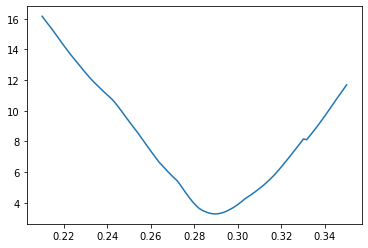

In [ ]:
plt.plot(delays, res)

In [ ]:
delays[res.argmin()]

0.28919191919191917

In [7]:
np.abs((delays - 0.214)).argmin()

3

In [8]:
res.min()

3.277735892557837

In [9]:
res.argmin()

56

24
[1.28282828 1.56565657 1.70707071]
['P11:LFHD', 'P11:LFIN', 'P11:RFHD', 'P11:RFIN']
['camera:cam_right              ' 'camera:cam_back               '
 'camera:cam_left               ' 'P11:LFHD                      '
 'P11:RFHD                      ' 'P11:LBHD                      '
 'P11:RBHD                      ' 'P11:C7                        '
 'P11:T10                       ' 'P11:CLAV                      '
 'P11:STRN                      ' 'P11:RBAK                      '
 'P11:LSHO                      ' 'P11:LUPA                      '
 'P11:LELB                      ' 'P11:LFRM                      '
 'P11:LWRA                      ' 'P11:LWRB                      '
 'P11:LFIN                      ' 'P11:RSHO                      '
 'P11:RUPA                      ' 'P11:RELB                      '
 'P11:RFRM                      ' 'P11:RWRA                      '
 'P11:RWRB                      ' 'P11:RFIN                      '
 'P11:LASI                      ' 'P11:RAS

/home/schiavazza/.local/lib/python3.10/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')


['camera:cam_right              ' 'camera:cam_back               '
 'camera:cam_left               ' 'P11:LFHD                      '
 'P11:RFHD                      ' 'P11:LBHD                      '
 'P11:RBHD                      ' 'P11:C7                        '
 'P11:T10                       ' 'P11:CLAV                      '
 'P11:STRN                      ' 'P11:RBAK                      '
 'P11:LSHO                      ' 'P11:LUPA                      '
 'P11:LELB                      ' 'P11:LFRM                      '
 'P11:LWRA                      ' 'P11:LWRB                      '
 'P11:LFIN                      ' 'P11:RSHO                      '
 'P11:RUPA                      ' 'P11:RELB                      '
 'P11:RFRM                      ' 'P11:RWRA                      '
 'P11:RWRB                      ' 'P11:RFIN                      '
 'P11:LASI                      ' 'P11:RASI                      '
 'P11:LPSI                      ' 'P11:RPSI                   

/home/schiavazza/.local/lib/python3.10/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')


24
[2.55555556 2.83838384 2.97979798 3.12121212]
['P11:LFHD', 'P11:LFIN', 'P11:RFHD', 'P11:RFIN']
['camera:cam_right              ' 'camera:cam_back               '
 'camera:cam_left               ' 'P11:LFHD                      '
 'P11:RFHD                      ' 'P11:LBHD                      '
 'P11:RBHD                      ' 'P11:C7                        '
 'P11:T10                       ' 'P11:CLAV                      '
 'P11:STRN                      ' 'P11:RBAK                      '
 'P11:LSHO                      ' 'P11:LUPA                      '
 'P11:LELB                      ' 'P11:LFRM                      '
 'P11:LWRA                      ' 'P11:LWRB                      '
 'P11:LFIN                      ' 'P11:RSHO                      '
 'P11:RUPA                      ' 'P11:RELB                      '
 'P11:RFRM                      ' 'P11:RWRA                      '
 'P11:RWRB                      ' 'P11:RFIN                      '
 'P11:LASI                     

/home/schiavazza/.local/lib/python3.10/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')


['camera:cam_right              ' 'camera:cam_back               '
 'camera:cam_left               ' 'P11:LFHD                      '
 'P11:RFHD                      ' 'P11:LBHD                      '
 'P11:RBHD                      ' 'P11:C7                        '
 'P11:T10                       ' 'P11:CLAV                      '
 'P11:STRN                      ' 'P11:RBAK                      '
 'P11:LSHO                      ' 'P11:LUPA                      '
 'P11:LELB                      ' 'P11:LFRM                      '
 'P11:LWRA                      ' 'P11:LWRB                      '
 'P11:LFIN                      ' 'P11:RSHO                      '
 'P11:RUPA                      ' 'P11:RELB                      '
 'P11:RFRM                      ' 'P11:RWRA                      '
 'P11:RWRB                      ' 'P11:RFIN                      '
 'P11:LASI                      ' 'P11:RASI                      '
 'P11:LPSI                      ' 'P11:RPSI                   

/home/schiavazza/.local/lib/python3.10/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')


['camera:cam_right              ' 'camera:cam_back               '
 'camera:cam_left               ' 'P11:LFHD                      '
 'P11:RFHD                      ' 'P11:LBHD                      '
 'P11:RBHD                      ' 'P11:C7                        '
 'P11:T10                       ' 'P11:CLAV                      '
 'P11:STRN                      ' 'P11:RBAK                      '
 'P11:LSHO                      ' 'P11:LUPA                      '
 'P11:LELB                      ' 'P11:LFRM                      '
 'P11:LWRA                      ' 'P11:LWRB                      '
 'P11:LFIN                      ' 'P11:RSHO                      '
 'P11:RUPA                      ' 'P11:RELB                      '
 'P11:RFRM                      ' 'P11:RWRA                      '
 'P11:RWRB                      ' 'P11:RFIN                      '
 'P11:LASI                      ' 'P11:RASI                      '
 'P11:LPSI                      ' 'P11:RPSI                   

/home/schiavazza/.local/lib/python3.10/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')


['camera:cam_right              ' 'camera:cam_back               '
 'camera:cam_left               ' 'P11:LFHD                      '
 'P11:RFHD                      ' 'P11:LBHD                      '
 'P11:RBHD                      ' 'P11:C7                        '
 'P11:T10                       ' 'P11:CLAV                      '
 'P11:STRN                      ' 'P11:RBAK                      '
 'P11:LSHO                      ' 'P11:LUPA                      '
 'P11:LELB                      ' 'P11:LFRM                      '
 'P11:LWRA                      ' 'P11:LWRB                      '
 'P11:LFIN                      ' 'P11:RSHO                      '
 'P11:RUPA                      ' 'P11:RELB                      '
 'P11:RFRM                      ' 'P11:RWRA                      '
 'P11:RWRB                      ' 'P11:RFIN                      '
 'P11:LASI                      ' 'P11:RASI                      '
 'P11:LPSI                      ' 'P11:RPSI                   

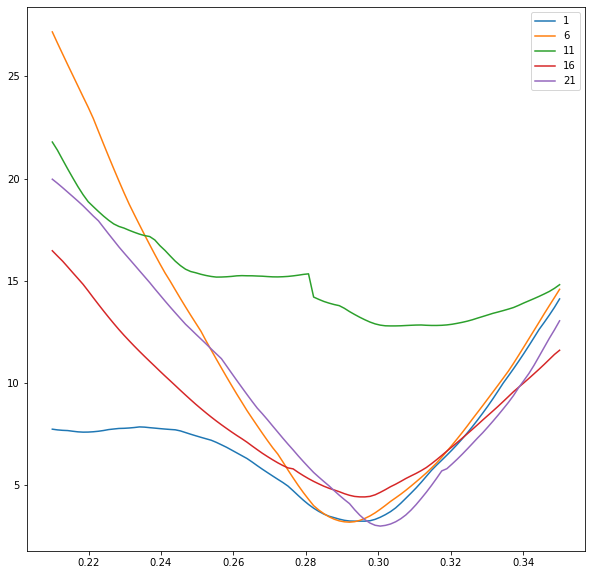

In [10]:
plt.figure(figsize=(10, 10))
for i in np.arange(1, 24, 5):
    res, delays = opt_delay(i)
    plt.plot(delays, res, label=f"{i}")
    print(i)
plt.legend()